# Imports

In [122]:
import string
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# config

In [123]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# load data

In [124]:
emotions_csv = pd.read_csv('NRC-Emotion-Lexicon-v0.92-English.csv', header=0)
emotions_csv.head()

,English,Positive,Negative,Anger,Anticipation,Disgust,Fear,Joy,Sadness,Surprise,Trust
0,aback,0,0,0,0,0,0,0,0,0,0
1,abacus,0,0,0,0,0,0,0,0,0,1
2,abandon,0,1,0,0,0,1,0,1,0,0
3,abandoned,0,1,1,0,0,1,0,1,0,0
4,abandonment,0,1,1,0,0,1,0,1,1,0


# load emotions into memory while ranking them (prefer negative over positive)

In [125]:
emotions = {
    'Anger': (1, 'negative'), 
    'Fear': (2, 'negative'),  
    'Disgust': (3, 'negative'), 
    'Sadness': (4, 'negative'),  
    'Surprise': (5, 'negative'),  
    'Anticipation': (6, 'positive'),  
    'Joy': (7, 'positive'),   
    'Trust': (8, 'positive'), 
}
def get_emotion_data(row):
    context = None
    for col, val in row.iteritems():
        
        # check emotion columns with value == 1
        if col in emotions and val == 1:
            
            # first time
            if context is None:
                context = (col, emotions[col])
                
            # prefer low rank context over high ones (i.e. prefer negative over positive)
            else:
                if emotions[col][0] < emotions[context[0]][0]:
                    context = (col, emotions[col])
                    
    # return the emotion text
    if context is not None:
        return context[0], context[1][1]
    return 'other', 'other'

In [126]:
emotions_dict = {}
for index, row in emotions_csv.iterrows():
    # lemmatize
    word = WordNetLemmatizer().lemmatize(str(row.English))
    context, category = get_emotion_data(row)
    emotions_dict[word] = {
        'context': context,
        'category': category
    }

print(len(emotions_dict), 'word(s)')

13922 word(s)


# load stopwords

In [127]:
stop_words = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself",
              "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself",
              "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these",
              "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do",
              "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while",
              "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before",
              "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again",
              "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each",
              "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than",
              "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]

# load tweets data

In [128]:
df = pd.read_csv('..\\tweets_sentiment.csv', header=0)

# analyse emotions
- clean text from punctuations
- remove stopwords
- return each word to its original form (lemmatization)
- `finally`, check text for any emotion reference word

In [129]:
def get_emotions(tweet):
    # clean string
    tweet = str(tweet)
    tweet = tweet.lower()
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))

    # get words
    tokenized_words = word_tokenize(tweet, "english")

    # remove stopwords
    final_words = []
    for word in tokenized_words:
        if word not in stop_words:
            final_words.append(word)

    # lemmatize words
    lemma_words = []
    for word in final_words:
        word = WordNetLemmatizer().lemmatize(word)
        lemma_words.append(word)

    # check emotion
    emotion = ['other', 'other']
    for word in lemma_words:
        if word in emotions_dict:
            if emotions_dict[word]['context']:
                emotion = [emotions_dict[word]['context'], emotions_dict[word]['category']]
            break

    # return emotion data
    return pd.Series(emotion)

In [130]:
df[['emotion', 'emotion_category']] = df.translated_text.apply(get_emotions)

# check data

In [131]:
df[['translated_text', 'emotion', 'emotion_category']].head()

,translated_text,emotion,emotion_category
0,#Corona #COVIDー19 Official Numbers in Lebanon ...,other,other
1,# Corona_Lebanon\n#coronavirus,other,other
2,"The management of the ""Palma"" resort explains ...",Trust,positive
3,Urgent: The Lebanese Ministry of Health: 415 C...,Fear,negative
4,"Finally, the 7 of September gets rid of the ge...",Disgust,negative


# functions to group data and visualize it

In [132]:
def group_emtions(df_):
    result = df_.groupby('emotion').count().reset_index()[['emotion', 'translated_text']]
    result = result.rename(columns={result.columns[1]: 'count_'})
    return result

def pie_plot(df_):
    fig1, ax1 = plt.subplots(figsize=(10, 7))
    ax1.pie(df_.count_.values.tolist(), labels=df_.emotion.values.tolist())
    ax1.axis('equal')
    plt.show()

# emotions and their tweet count

In [133]:
group_emtions(df)

,emotion,count_
0,Anger,2276
1,Anticipation,2866
2,Disgust,384
3,Fear,5792
4,Joy,1665
5,Sadness,833
6,Surprise,798
7,Trust,3126
8,other,33148


# positive emotions distribution

In [134]:
pos_data = group_emtions( df[ (df.sentiment_label2 == 'POSITIVE') & (df.emotion_category == 'positive') ] )
pos_data

,emotion,count_
0,Anticipation,1407
1,Joy,671
2,Trust,1478


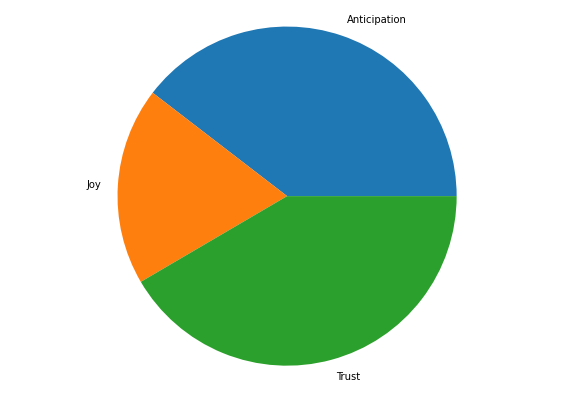

In [135]:
pie_plot(pos_data) 

# negative emotions distribution

In [136]:
neg_data = group_emtions( df[ (df.sentiment_label2 == 'NEGATIVE') & (df.emotion_category == 'negative') ] )
neg_data

,emotion,count_
0,Anger,1578
1,Disgust,225
2,Fear,3470
3,Sadness,572
4,Surprise,320


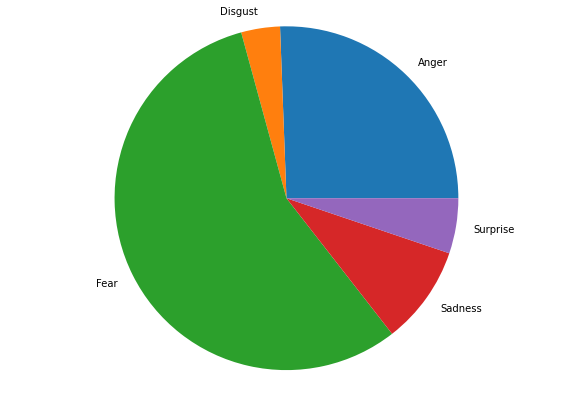

In [137]:
pie_plot(neg_data) 

# handling `other` emotion data

In [138]:
other_data = df[df.emotion == 'other']
other_data['text'].count()

33148

In [139]:
other_emotions_csv = pd.read_csv('emotions.csv', header=0)

In [140]:
other_emotions = {}
for index, row in other_emotions_csv.iterrows():
    # lemmatize
    word = WordNetLemmatizer().lemmatize(row.word)
    other_emotions[word] = {
        'context': row.context,
        'category': row.category
    }

print(len(other_emotions), 'word(s)')

344 word(s)


In [141]:
def get_other_emotions(tweet):
    # clean string
    tweet = str(tweet)
    tweet = tweet.lower()
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))

    # get words
    tokenized_words = word_tokenize(tweet, "english")

    # remove stopwords
    final_words = []
    for word in tokenized_words:
        if word not in stop_words:
            final_words.append(word)

    # lemetaize words
    lemma_words = []
    for word in final_words:
        word = WordNetLemmatizer().lemmatize(word)
        lemma_words.append(word)

    # check emotion
    emotion = ['other', 'other']
    for word in lemma_words:
        if word in other_emotions:
            emotion = [other_emotions[word]['context'], other_emotions[word]['category']]
            break

    # retunr a list of emotions
    return pd.Series(emotion, index=['emotion', 'emotion_category'])

In [142]:
other_emotions_mask = df.emotion == 'other'
df.loc[other_emotions_mask, ['emotion', 'emotion_category']] = df[other_emotions_mask].translated_text.apply(get_other_emotions)

In [143]:
df[['translated_text', 'emotion', 'emotion_category']].head()

,translated_text,emotion,emotion_category
0,#Corona #COVIDー19 Official Numbers in Lebanon ...,other,other
1,# Corona_Lebanon\n#coronavirus,other,other
2,"The management of the ""Palma"" resort explains ...",Trust,positive
3,Urgent: The Lebanese Ministry of Health: 415 C...,Fear,negative
4,"Finally, the 7 of September gets rid of the ge...",Disgust,negative


In [144]:
other_data = df[other_emotions_mask]
other_data['text'].count()

33148

# positive emotions distribution

In [145]:
pos_data = group_emtions( df[other_emotions_mask] )
pos_data

,emotion,count_
0,angry,232
1,anxious,424
2,disappointed,6
3,hopeful,950
4,news,3815
5,other,27489
6,sad,232


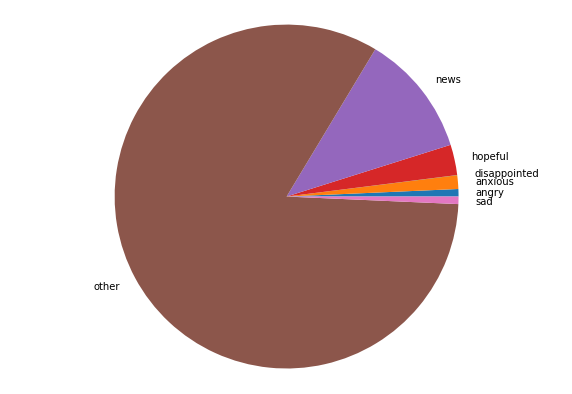

In [146]:
pie_plot(pos_data) 